In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import cell_order_log_analysis
import sys
sys.path.append('../radio_api')
import constants

In [2]:
FIG_SIZE = (8,5)
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = True

RESERVATION = 'OTA_THP-TCP_THP-UDP'
LAT_S_IDX = 0
THP_S_IDX = 1
reservation_data_dir = '../data/' + RESERVATION + '/'

if (SAVE_FIG):
    reservation_out_dir = '../outputs/' + RESERVATION + '/'
    if (not os.path.exists(reservation_out_dir)):
        os.mkdir(reservation_out_dir)

SLA_PERIOD = 30 # seconds over which the SLAs are negotiated
OUTLIER_PERCENTILE = 5 # Percentile to clip-off from both ends for each SLA period
N_PRB_PER_RBG = 3

In [3]:
def filter_bs_sla_stats(bs_data, budgets, ts_start):

    for user_id, supply_times in budgets['supply_times'].items():
        port_offset = int(user_id[0].split('.')[-1])
        sid = port_offset % constants.SLICE_NUM
        
        bs_data[sid]['filtered_ts_sec'] = []
        bs_data[sid]['filtered_lat_msec'] = []
        bs_data[sid]['filtered_thp_mbps'] = []
        for supply_time in supply_times:
            ts_filter = np.logical_and(bs_data[sid]['raw_ts_sec'] >= supply_time,
                                       bs_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
            if (not ts_filter.any()):
                continue

            sla_ts_sec = bs_data[sid]['raw_ts_sec'][ts_filter]
            bs_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

            if ('raw_lat_msec' in bs_data[sid].keys()):
                sla_lat_msec = bs_data[sid]['raw_lat_msec'][ts_filter]
                lat_outlier_filter = np.logical_and(sla_lat_msec <= np.percentile(sla_lat_msec, 100 - OUTLIER_PERCENTILE),
                                                    sla_lat_msec >= np.percentile(sla_lat_msec, OUTLIER_PERCENTILE))
                if (lat_outlier_filter.any()):
                    bs_data[sid]['filtered_lat_msec'].append(np.mean(sla_lat_msec[lat_outlier_filter]))
                else:
                    bs_data[sid]['filtered_lat_msec'].append(np.median(sla_lat_msec))

            sla_thp_mbps = bs_data[sid]['raw_tx_mbps'][ts_filter]
            thp_outlier_filter = np.logical_and(sla_thp_mbps <= np.percentile(sla_thp_mbps, 100 - OUTLIER_PERCENTILE),
                                                sla_thp_mbps >= np.percentile(sla_thp_mbps, OUTLIER_PERCENTILE))
            if (thp_outlier_filter.any()):
                bs_data[sid]['filtered_thp_mbps'].append(np.mean(sla_thp_mbps[thp_outlier_filter]))
            else:
                bs_data[sid]['filtered_thp_mbps'].append(np.median(sla_thp_mbps))

        bs_data[sid]['filtered_ts_sec'] = np.array(bs_data[sid]['filtered_ts_sec'])
        bs_data[sid]['filtered_lat_msec'] = np.array(bs_data[sid]['filtered_lat_msec'])
        bs_data[sid]['filtered_thp_mbps'] = np.array(bs_data[sid]['filtered_thp_mbps'])

In [4]:
def filter_ue_sla_stats(ue_data, sid):

    ue_data[sid]['filtered_ts_sec'] = []
    ue_data[sid]['filtered_rtt_msec'] = []
    ue_data[sid]['filtered_mbps'] = []
    for supply_time in ue_data[sid]['supply_times']:
        ts_filter = np.logical_and(ue_data[sid]['raw_ts_sec'] >= supply_time,
                                   ue_data[sid]['raw_ts_sec'] < supply_time + SLA_PERIOD + 1)
        if (not ts_filter.any()):
            continue

        sla_ts_sec = ue_data[sid]['raw_ts_sec'][ts_filter]
        ue_data[sid]['filtered_ts_sec'].append(np.max(sla_ts_sec))

        if (len(ue_data[sid]['raw_rtt_msec']) > 0):
            sla_rtt_msec = ue_data[sid]['raw_rtt_msec'][ts_filter]
            lat_outlier_filter = np.logical_and(sla_rtt_msec <= np.percentile(sla_rtt_msec, 100 - OUTLIER_PERCENTILE),
                                                sla_rtt_msec >= np.percentile(sla_rtt_msec, OUTLIER_PERCENTILE))
            if (lat_outlier_filter.any()):
                ue_data[sid]['filtered_rtt_msec'].append(np.mean(sla_rtt_msec[lat_outlier_filter]))
            else:
                ue_data[sid]['filtered_rtt_msec'].append(np.median(sla_rtt_msec))

        sla_mbps = ue_data[sid]['raw_mbps'][ts_filter]
        thp_outlier_filter = np.logical_and(sla_mbps <= np.percentile(sla_mbps, 100 - OUTLIER_PERCENTILE),
                                            sla_mbps >= np.percentile(sla_mbps, OUTLIER_PERCENTILE))
        if (thp_outlier_filter.any()):
            ue_data[sid]['filtered_mbps'].append(np.mean(sla_mbps[thp_outlier_filter]))
        else:
            ue_data[sid]['filtered_mbps'].append(np.median(sla_mbps))

    ue_data[sid]['filtered_ts_sec'] = np.array(ue_data[sid]['filtered_ts_sec'])
    ue_data[sid]['filtered_rtt_msec'] = np.array(ue_data[sid]['filtered_rtt_msec'])
    ue_data[sid]['filtered_mbps'] = np.array(ue_data[sid]['filtered_mbps'])

In [5]:
bs_log_filename = reservation_data_dir + 'cell-order.log'
bs_data, bs_budgets, bs_ts_start = \
    cell_order_log_analysis.read_cell_order_log(bs_log_filename, consider_dst=True)
filter_bs_sla_stats(bs_data, bs_budgets, bs_ts_start)

ue_slices = [0, 1]
traffic_types = ['TCP', 'UDP']
ue_filenames = {}
ue_data = {}
for ue_slice in ue_slices:
    ue_filenames[ue_slice] = \
        reservation_data_dir + 'cell-order-ue{}.log'.format(ue_slice + 2)
    cur_data, s_id, ue_ts_start = \
        cell_order_log_analysis.read_cell_order_ue_log(ue_filenames[ue_slice], bs_ts_start, consider_dst=True)
    assert s_id == ue_slice
    assert s_id in bs_data.keys()
    ue_data[ue_slice] = cur_data
    filter_ue_sla_stats(ue_data, s_id)

Data for 636.2860000133514 seconds has been extracted
UE Data for 589.941999912262 seconds has been extracted
UE Data for 631.941999912262 seconds has been extracted


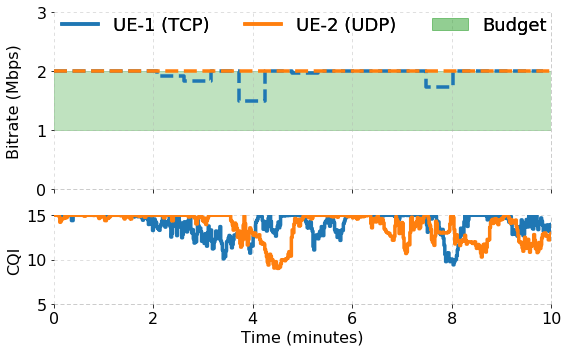

In [6]:
XMAX = 10
f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=FIG_SIZE)

legend_lines = []
for ue_slice in ue_slices:
    ax1.step(np.insert(ue_data[ue_slice]['filtered_ts_sec'] / 60, 0, 0), 
            np.insert(ue_data[ue_slice]['filtered_mbps'], 0, ue_data[ue_slice]['filtered_mbps'][0]), 
            where='pre', linestyle='--', 
            label='UE-{} ({})'.format(ue_slice + 1, traffic_types[ue_slice]), linewidth=3.5, color='C{}'.format(ue_slice))
    # ax1.step(np.insert(bs_data[ue_slice]['filtered_ts_sec'] / 60, 0, 0), 
    #         np.insert(bs_data[ue_slice]['filtered_thp_mbps'], 0, bs_data[ue_slice]['filtered_thp_mbps'][0]), 
    #         where='pre', label='BS for UE{}'.format(ue_slice), linewidth=3.5, color='C{}'.format(ue_slice), linestyle='--')
    legend_lines.append(Line2D([0,1],[0,1],linestyle='-', linewidth=3.5, color='C{}'.format(ue_slice)))

    # cnt = 1
    thp_budget_lo = bs_budgets['slice_tx_rate_budget_mbps'][ue_slice][0]
    thp_budget_hi = bs_budgets['slice_tx_rate_budget_mbps'][ue_slice][1]
    # thp_budget_width = thp_budget_hi - thp_budget_lo
    # user_id = list(bs_budgets['supply_times'])[ue_slice]
    # for supply_time in bs_budgets['supply_times'][user_id]:
    #     ts_minutes = (supply_time) / 60
    #     if (cnt == 1 and ue_slice == 0):
    #         ax1.add_patch(Rectangle((ts_minutes, thp_budget_lo), SLA_PERIOD / 60, 
    #                                 thp_budget_width, color='C2', alpha=0.3, 
    #                                 label='Budget'))
    #     else:
    #         ax1.add_patch(Rectangle((ts_minutes, thp_budget_lo), SLA_PERIOD / 60, 
    #                                 thp_budget_width, color='C2', alpha=0.3))
    #     cnt += 1
ax1.axhspan(thp_budget_lo, thp_budget_hi, xmin=0, xmax=XMAX, 
            color='C2', alpha=0.3, label='Budget')

# ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Bitrate (Mbps)', fontsize=FONT_SIZE)
ax1.tick_params(axis='y', labelsize=FONT_SIZE)
# ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.get_xaxis().set_ticklabels([])
ax1.set_ylim((0, 3))
ax1.set_xlim([0,XMAX])
# ax1.xaxis.set_ticks(np.arange(0, 13))

handles, labels = ax1.get_legend_handles_labels()
handles[:len(legend_lines)] = legend_lines
order = [0, 1, 2] #specify order of items in legend
leg = ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc='upper left', frameon=False, fontsize=FONT_SIZE+2, ncol=3,
                 bbox_to_anchor=[-0.015,1.07])
# ax1.legend([handles[2]],[labels[2]],
#            loc='lower left', frameon=False, fontsize=FONT_SIZE+2,
#            bbox_to_anchor=[-0.01,0.07])
ax1.add_artist(leg)

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

for ue_slice in ue_slices:
    ax2.step(np.insert(bs_data[ue_slice]['raw_ts_sec'] / 60, 0, 0), 
            np.insert(bs_data[ue_slice]['raw_cqi'], 0, bs_data[ue_slice]['raw_cqi'][0]), 
            where='pre', linewidth=3.5, color='C{}'.format(ue_slice), linestyle='-',
            label='UE{}'.format(ue_slice))

ax2.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax2.set_ylabel('CQI', fontsize=FONT_SIZE)
ax2.tick_params(axis='y', labelsize=FONT_SIZE)
ax2.tick_params(axis='x', labelsize=FONT_SIZE)
ax2.set_ylim((5, 15))
ax2.yaxis.set_ticks(np.arange(5,16,5))
ax2.set_xlim([0, XMAX])
# ax2.xaxis.set_ticks(np.arange(13))

ax2.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

f.tight_layout()  
f.align_ylabels()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'ota_thp_and_cqi_.pdf')

plt.show()

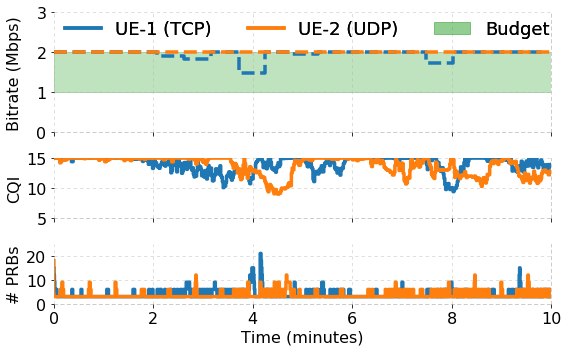

In [7]:
XMAX = 10
f, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2, 1, 1]}, figsize=FIG_SIZE)

legend_lines = []
for ue_slice in ue_slices:
    ax1.step(np.insert(ue_data[ue_slice]['filtered_ts_sec'] / 60, 0, 0), 
            np.insert(ue_data[ue_slice]['filtered_mbps'], 0, ue_data[ue_slice]['filtered_mbps'][0]), 
            where='pre', linestyle='--', 
            label='UE-{} ({})'.format(ue_slice + 1, traffic_types[ue_slice]), linewidth=3.5, color='C{}'.format(ue_slice))
    # ax1.step(np.insert(bs_data[ue_slice]['filtered_ts_sec'] / 60, 0, 0), 
    #         np.insert(bs_data[ue_slice]['filtered_thp_mbps'], 0, bs_data[ue_slice]['filtered_thp_mbps'][0]), 
    #         where='pre', label='BS for UE{}'.format(ue_slice), linewidth=3.5, color='C{}'.format(ue_slice), linestyle='--')
    legend_lines.append(Line2D([0,1],[0,1],linestyle='-', linewidth=3.5, color='C{}'.format(ue_slice)))

    # cnt = 1
    thp_budget_lo = bs_budgets['slice_tx_rate_budget_mbps'][ue_slice][0]
    thp_budget_hi = bs_budgets['slice_tx_rate_budget_mbps'][ue_slice][1]
    # thp_budget_width = thp_budget_hi - thp_budget_lo
    # user_id = list(bs_budgets['supply_times'])[ue_slice]
    # for supply_time in bs_budgets['supply_times'][user_id]:
    #     ts_minutes = (supply_time) / 60
    #     if (cnt == 1 and ue_slice == 0):
    #         ax1.add_patch(Rectangle((ts_minutes, thp_budget_lo), SLA_PERIOD / 60, 
    #                                 thp_budget_width, color='C2', alpha=0.3, 
    #                                 label='Budget'))
    #     else:
    #         ax1.add_patch(Rectangle((ts_minutes, thp_budget_lo), SLA_PERIOD / 60, 
    #                                 thp_budget_width, color='C2', alpha=0.3))
    #     cnt += 1
ax1.axhspan(thp_budget_lo, thp_budget_hi, xmin=0, xmax=XMAX, 
            color='C2', alpha=0.3, label='Budget')

# ax1.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax1.set_ylabel('Bitrate (Mbps)', fontsize=FONT_SIZE)
ax1.tick_params(axis='y', labelsize=FONT_SIZE)
# ax1.tick_params(axis='x', labelsize=FONT_SIZE)
ax1.get_xaxis().set_ticklabels([])
ax1.set_ylim((0, 3))
ax1.yaxis.set_ticks(np.arange(0,4,1))
ax1.set_xlim([0,XMAX])
# ax1.xaxis.set_ticks(np.arange(0, 13))

handles, labels = ax1.get_legend_handles_labels()
handles[:len(legend_lines)] = legend_lines
order = [0, 1, 2] #specify order of items in legend
leg = ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc='upper left', frameon=False, fontsize=FONT_SIZE+2, ncol=3,
                 bbox_to_anchor=[-0.01,1.07])
# ax1.legend([handles[2]],[labels[2]],
#            loc='lower left', frameon=False, fontsize=FONT_SIZE+2,
#            bbox_to_anchor=[-0.01,0.07])
ax1.add_artist(leg)

ax1.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

for ue_slice in ue_slices:
    ax2.step(np.insert(bs_data[ue_slice]['raw_ts_sec'] / 60, 0, 0), 
            np.insert(bs_data[ue_slice]['raw_cqi'], 0, bs_data[ue_slice]['raw_cqi'][0]), 
            where='pre', linewidth=3.5, color='C{}'.format(ue_slice), linestyle='-',
            label='UE{}'.format(ue_slice))

# ax2.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax2.set_ylabel('CQI', fontsize=FONT_SIZE)
ax2.tick_params(axis='y', labelsize=FONT_SIZE)
# ax2.tick_params(axis='x', labelsize=FONT_SIZE)
ax2.get_xaxis().set_ticklabels([])
ax2.set_ylim((5, 15))
ax2.yaxis.set_ticks(np.arange(5,16,5))
ax2.set_xlim([0, XMAX])
# ax2.xaxis.set_ticks(np.arange(13))

ax2.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

for ue_slice in ue_slices:
    ax3.step(np.insert(bs_data[ue_slice]['raw_ts_sec'] / 60, 0, 0), 
             np.insert(bs_data[ue_slice]['raw_n_rbgs'], 0, bs_data[ue_slice]['raw_n_rbgs'][0]) * N_PRB_PER_RBG, 
             where='pre', linewidth=3.5, color='C{}'.format(ue_slice), linestyle='-',
             label='UE{}'.format(ue_slice))

ax3.set_xlabel('Time (minutes)', fontsize=FONT_SIZE)
ax3.set_ylabel('# PRBs', fontsize=FONT_SIZE)
ax3.tick_params(axis='y', labelsize=FONT_SIZE)
ax3.tick_params(axis='x', labelsize=FONT_SIZE)
ax3.set_ylim((0, 25))
ax3.yaxis.set_ticks(np.arange(0,26,10))
ax3.set_xlim([0, XMAX])
# ax2.xaxis.set_ticks(np.arange(13))

ax3.grid(axis='both', alpha=0.5, linestyle=LINE_STYLE)

ax3.spines['top'].set_visible(False)
# ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines["right"].set_linestyle(LINE_STYLE)
ax3.spines["right"].set_alpha(0.5)
ax3.spines["right"].set_color('gray')
ax3.spines["left"].set_linestyle(LINE_STYLE)
ax3.spines["left"].set_alpha(0.5)
ax3.spines["left"].set_color('gray')
ax3.spines["top"].set_linestyle(LINE_STYLE)
ax3.spines["top"].set_alpha(0.5)
ax3.spines["top"].set_color('gray')
ax3.spines["bottom"].set_linestyle(LINE_STYLE)
ax3.spines["bottom"].set_alpha(0.5)
ax3.spines["bottom"].set_color('gray')

f.tight_layout()  
f.align_ylabels()

if SAVE_FIG:
    plt.savefig(reservation_out_dir + 'ota_thp_cqi_and_prb.pdf')

plt.show()